<a href="https://colab.research.google.com/github/ShravyaMalogi/PROJECT_drafts/blob/main/Age_Detection/ad2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

bad_files = []

with zipfile.ZipFile('/content/drive/MyDrive/projects/datasets/imdbwiki.zip', 'r') as zipf:
    for file in zipf.filelist:
        try:
            zipf.open(file.filename).read()
        except:
            bad_files.append(file.filename)

print("🛑 Corrupted files found:")
for bf in bad_files:
    print(bf)

🛑 Corrupted files found:
imdb-clean-1024/imdb-clean-1024/22/nm0266422_rm3838610432_1974-9-19_2005.jpg
imdb-clean-1024/imdb-clean-1024/24/nm1861624_rm3706501120_1982-11-15_2010.jpg
imdb-clean-1024/imdb-clean-1024/25/nm1553725_rm2946674688_1985-3-15_2011.jpg
imdb-clean-1024/imdb-clean-1024/41/nm0266441_rm2134412800_1961-5-13_1994.jpg
imdb-clean-1024/imdb-clean-1024/43/nm0001743_rm2994522112_1948-1-29_1984.jpg
imdb-clean-1024/imdb-clean-1024/73/nm0001173_rm2329378816_1968-3-12_2008.jpg


In [ ]:
import zipfile
import os

# Path to the zip file on your Google Drive
zip_path = '/content/drive/MyDrive/projects/datasets/imdbwiki.zip'  # change this
extract_path = '/content/imdb-wiki_data'

# List of corrupted files inside the ZIP to skip
corrupted_files = bad_files

# Extract all except corrupted files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file not in corrupted_files:
            try:
                zip_ref.extract(file, extract_path)
            except Exception as e:
                print(f"Error extracting {file}: {e}")
        else:
            print(f"Skipping corrupted file: {file}")


Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/22/nm0266422_rm3838610432_1974-9-19_2005.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/24/nm1861624_rm3706501120_1982-11-15_2010.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/25/nm1553725_rm2946674688_1985-3-15_2011.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/41/nm0266441_rm2134412800_1961-5-13_1994.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/43/nm0001743_rm2994522112_1948-1-29_1984.jpg
Skipping corrupted file: imdb-clean-1024/imdb-clean-1024/73/nm0001173_rm2329378816_1968-3-12_2008.jpg


# Code

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/imdb-wiki_data/imdb_train_new_1024.csv")       # contains 'filename', 'age'
val_df = pd.read_csv("/content/imdb-wiki_data/imdb_valid_new_1024.csv")           # optional but recommended
test_df = pd.read_csv("/content/imdb-wiki_data/imdb_test_new_1024.csv")         # contains test data

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (183887, 10)
Val: (45972, 10)
Test: (56087, 10)


In [ ]:
# === Step 2: Image data generators with augmentation ===

# Path to the folder that contains folders like 00, 01, ..., 99
img_dir = "/content/imdb-wiki_data/imdb-clean-1024/imdb-clean-1024"  # Update if needed

img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col='filename',
    y_col='age',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col='filename',
    y_col='age',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=img_dir,
    x_col='filename',
    y_col='age',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 183884 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 45972 validated image filenames.
Found 56084 validated image filenames.


In [ ]:
# === Step 3: Build the MobileNetV2 model ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# === Step 4: Compile model ===
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=['mae'])

In [ ]:
# === Step 5: Set up callbacks ===
early_stop = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, min_lr=1e-6, monitor='val_loss')

In [11]:
# === Step 6: Train the model ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
1231/5747 ━━━━━━━━━━━━━━━━━━━━ 2:06:22 2s/step - loss: 11.4756 - mae: 11.4756

KeyboardInterrupt: 

In [ ]:
# === Step 7: Unfreeze and fine-tune the whole base model (optional but recommended) ===
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='mae', metrics=['mae'])

In [ ]:
# Fine-tune
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# Testing

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load your test CSV
test_df = pd.read_csv("/content/imdb-wiki_data/imdb_test_new_1024.csv")

# 2. Set the base image directory (where the 00-99 folders are stored)
test_img_dir = "/content/imdb-wiki_data/imdb-clean-1024/imdb-clean-1024/"  # Update if different

# 3. Create ImageDataGenerator for testing (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Create test generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img_dir,
    x_col='filename',
    y_col='age',  # required for evaluation
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw',  # for regression
    shuffle=False
)


Found 56084 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(test_gen)
print("Test Loss (MAE):", test_loss, test_mae)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 116s 66ms/step - loss: 122.5519 - mae: 8.4820
Test Loss (MAE): 117.02662658691406 8.322798728942871


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 110s 62ms/step


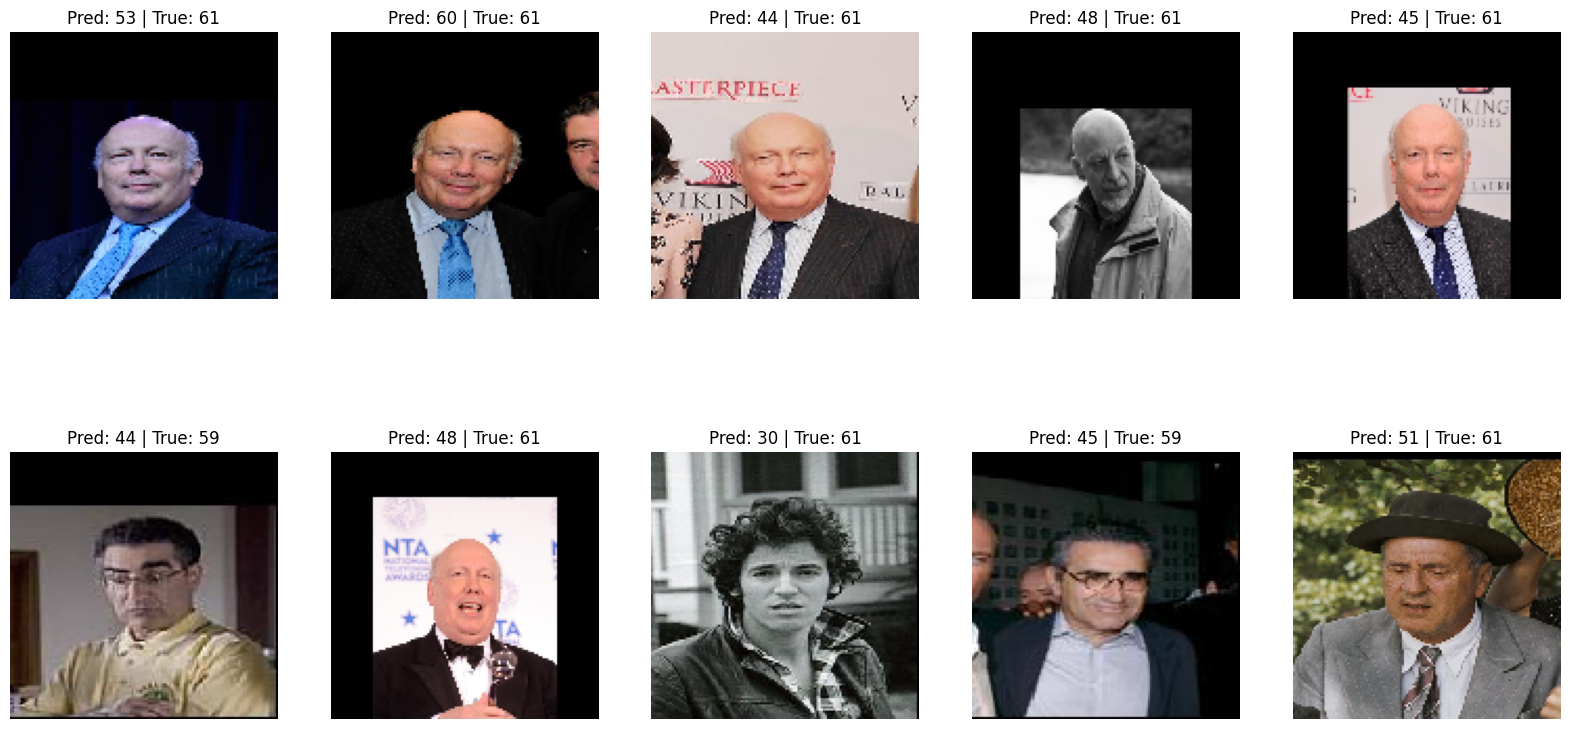

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predict ages using the model
preds = model.predict(test_gen, verbose=1)
preds = preds.flatten()

# 2. Show first 10 images from test set with predicted and actual age
num_images = 10
images, labels = next(test_gen)  # one batch
plt.figure(figsize=(20, 10))

for i in range(num_images):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

    # Optional: show actual age if available
    actual_age = labels[i] if labels is not None else "?"
    predicted_age = int(preds[i])

    ax.set_title(f"Pred: {predicted_age} | True: {int(actual_age)}")

In [ ]:
import numpy as np

# Reset the generator to ensure it starts from the beginning
test_gen.reset()

# Predict ages using the trained model
preds = model.predict(test_gen, verbose=1)
preds = preds.flatten()  # Ensure 1D array

# Get true age labels from the generator
true_labels = test_gen.labels

# Ensure both arrays are the same length
print(f"Predictions: {len(preds)}, True Labels: {len(true_labels)}")

# Calculate accuracy within ±5 years
within_5_years = np.abs(preds - true_labels) <= 5
accuracy_within_5 = np.mean(within_5_years)
print(f"Accuracy within ±5 years: {accuracy_within_5 * 100:.2f}%")


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 114s 65ms/step
Predictions: 56084, True Labels: 56084
Accuracy within ±5 years: 38.60%
